In [1]:
# Tianyu Lu
# HW2_question2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,mean_squared_error
import random
from sklearn import datasets

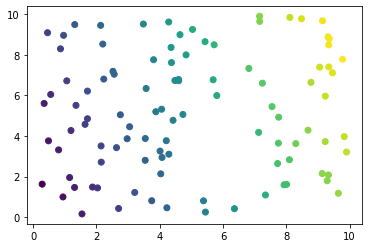

In [2]:
df = pd.read_csv('regression.csv')
x=df.values[:, 0:2]
y=df.values[:,2]
plt.scatter(x[:, 0], x[:, 1],c=y)
plt.show() 

In [3]:
# divide x, y into k list of same size
def getSplitData(x, y, k):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    pList = np.array_split(np.array(arr), k)
    xlist, ylist = [], []
    for fold in pList:
        xlist.append(x[fold])
        ylist.append(y[fold])
    return xlist, ylist

# randomly draw n samples from x, y
def drawSample(x, y, n):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    p1, p2 = arr[:n], arr[n:]
    return x[p1], x[p2], y[p1], y[p2]

# return model trained on x, y;
# and training error
def crossValidation(x, y):
    #split data for cross-validation
    xlist, ylist = getSplitData(x, y, 5)
    trainErr = []
    for i in range(5):
        model = LinearRegression()
        xtest, ytest = xlist[i], ylist[i]
        xtrain = np.concatenate((xlist[:i] + xlist[i+1:]))
        ytrain = np.concatenate((ylist[:i] + ylist[i+1:]))
        model.fit(xtrain, ytrain)
        trainErr.append(mean_squared_error(ytest, model.predict(xtest)))
        model = LinearRegression()
    model.fit(x, y)
    return model, np.mean(trainErr)

In [10]:
# passive learning 
def randomSample(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 10) # observed and unobserved data
    trainError, testError = [], []
    while len(xUnob) > 0:
        # train model + calculate loss
        model, train = crossValidation(xObs, yObs) 
        trainError.append(train)
        testError.append(mean_squared_error(yUnob, model.predict(xUnob)))
        # update sample
        xNew, xUnob, yNew, yUnob = drawSample(xUnob, yUnob, 1)
        xObs = np.concatenate((xObs, xNew))
        yObs = np.concatenate((yObs, yNew))
    return trainError, testError

In [11]:
# train model with random sampling for 10 simulation
obs, unobs = [], []
for i in range(10):
    random.seed(i)
    print(i)
    train, test = randomSample(x, y)
    obs.append(train)
    unobs.append(test)
    
# calculate mean and std for 10 simulation
passive_unobsMean = [np.mean(i) for i in np.transpose(np.array(unobs))]
passive_unobsStd = [np.std(i) for i in np.transpose(np.array(unobs))]
print("first round", passive_unobsMean[0], passive_unobsStd[0])

0
1
2
3
4
5
6
7
8
9
first round 0.030988293581783444 0.006587124907789233


In [13]:
# uncertain sampling

def uncertainSample(model, xtrain, ytrain, xtest, ytest):
    n = len(xtrain)
    sxx1 = sum(xtrain[:, 0])**2-sum(xtrain[:,0])**2/n # feature x1
    sxx2 = sum(xtrain[:, 1])**2-sum(xtrain[:,1])**2/n #feature x2
    s = mean_squared_error(ytrain, model.predict(xtrain))*n/(n-2)
    # calculate variance in all ytest predictions
    var = [s**2*( 1/n + (x[0]-np.mean(xtrain[:,0]))**2/sxx1 \
                 + (x[1]-np.mean(xtrain[:,1]))**2/sxx2) for x in xtest]
    # selects the greatest variance/uncertainty
    p = np.argmax(var) 
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

def uncertainTrain(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 10)
    trainError, testError = [], []
    while len(xUnob) > 0:
        model, train = crossValidation(xObs, yObs) 
        trainError.append(train)
        testError.append(mean_squared_error(yUnob, model.predict(xUnob)))
        # update sample
        xNew, yNew, xUnob, yUnob = uncertainSample(model,xObs, yObs, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return trainError, testError

In [14]:
obsAccuracy2, unobsAccuracy2 = [], []
for i in range(10):
    random.seed(i)
    print(i)
    train2, test2 = uncertainTrain(x, y)
    obsAccuracy2.append(train2)
    unobsAccuracy2.append(test2)

# calculate metrics
uncertain_unobsMean = [np.mean(i) for i in np.transpose(np.array(unobsAccuracy2))]
uncertain_unobsStd = [np.std(i) for i in np.transpose(np.array(unobsAccuracy2))]
print("first round", uncertain_unobsMean[0], uncertain_unobsStd[0])

0
1
2
3
4
5
6
7
8
9
first round 0.030988293581783444 0.006587124907789233


In [15]:
# draw samples uniformly with replacement from training 
# return trained committee of models 
def bagging(xtrain, ytrain, n):
    l = [i for i in range(len(xtrain))]
    committee=[]
    for i in range(n):
        pos = np.random.choice(l, size=len(xtrain), replace=True)
        bagX, bagY = xtrain[pos], ytrain[pos]
        model = LinearRegression()
        model.fit(bagX, bagY)
        committee.append(model)
    return committee

# find the data that has highest disagreement in the committee
def queryCommittee(models, xtest, ytest, n):
    var = []
    for x in xtest:
        # get prediction from all models
        pred =[models[i].predict(x.reshape(1,-1)) for i in range(n)]
        var.append(np.var(pred))
    p = np.argmax(var) 
    return xtest[p], ytest[p], np.delete(xtest, p, 0), np.delete(ytest, p)

In [16]:
# q1: query by committee
# using a random forest with 10 trees
def trainQueryCommittee(x, y):
    xObs, xUnob, yObs, yUnob = drawSample(x, y, 10) 
    trainAcc, testAcc = [], []
    while len(xUnob) > 0:
        model, train = crossValidation(xObs, yObs) 
        trainAcc.append(train)
        testAcc.append(mean_squared_error(yUnob, model.predict(xUnob)))
        # update sample
        committee = bagging(xObs, yObs, 10)
        xNew, yNew, xUnob, yUnob = queryCommittee(committee, xUnob, yUnob, 10)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return trainAcc, testAcc

In [17]:
# run queryByCommittee
obs, unobs = [], []
for i in range(10):
    random.seed(i)
    print(i)
    train, test = trainQueryCommittee(x, y)
    obs.append(train)
    unobs.append(test)
    
# calculate mean and std for 10 simulation
qbc_unobsMean = [np.mean(i) for i in np.transpose(np.array(unobs))]
qbc_unobsStd = [np.std(i) for i in np.transpose(np.array(unobs))]
print("first round", qbc_unobsMean[0], qbc_unobsStd[0])

0
1
2
3
4
5
6
7
8
9
first round 0.030988293581783444 0.006587124907789233


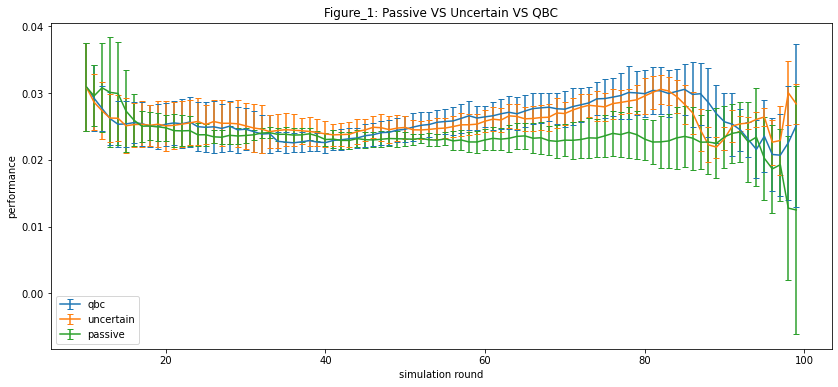

In [21]:
# plot passive learning
# adjusted to exclude first 5 rounds
xaxis = np.arange(len(qbc_unobsMean)) +10
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, qbc_unobsMean, yerr = qbc_unobsStd,  label = 'qbc', capsize=3)
plt.errorbar(xaxis, uncertain_unobsMean, yerr = uncertain_unobsStd, label = 'uncertain', capsize=3)
plt.errorbar(xaxis, passive_unobsMean, yerr = passive_unobsStd,  label = 'passive', capsize=3)

plt.xlabel("simulation round")
plt.ylabel("performance")
plt.title("Figure_1: Passive VS Uncertain VS QBC")
plt.legend()
plt.show()

In [12]:
# design of experiment
# 100 choose 30 -> randomly select 1000 times
def doe(x, y):
    xMax, xUnMax, yMax, yUnMax = drawSample(x, y, 30)
    for i in range(10000):
        xObs, xUnob, yObs, yUnob = drawSample(x, y, 30)
        xtx = np.matmul(np.transpose(xObs), xObs)
        curX = np.linalg.det(np.matmul(np.transpose(xMax), xMax))
        if np.linalg.det(xtx) > curX:
            xMax = xObs
            xUnMax = xUnob
            yMax = yObs
            yUnMax = yUnob
    model, train = crossValidation(xMax, yMax)
    return train, mean_squared_error(yUnMax, model.predict(xUnMax))

In [13]:
# run DOE
# run queryByCommittee
performance = []
for i in range(10):
    random.seed(i)
    print(i)
    _, test = doe(x, y)
    performance.append(test)
    
print(performance)

0
1
2
3
4
5
6
7
8
9
[0.023128174292450194, 0.021253185809711066, 0.023032137909347355, 0.025779472482859136, 0.02221905473423298, 0.026788359943367732, 0.020990713028665824, 0.02204635642256265, 0.022716921092224476, 0.020480812396701423]


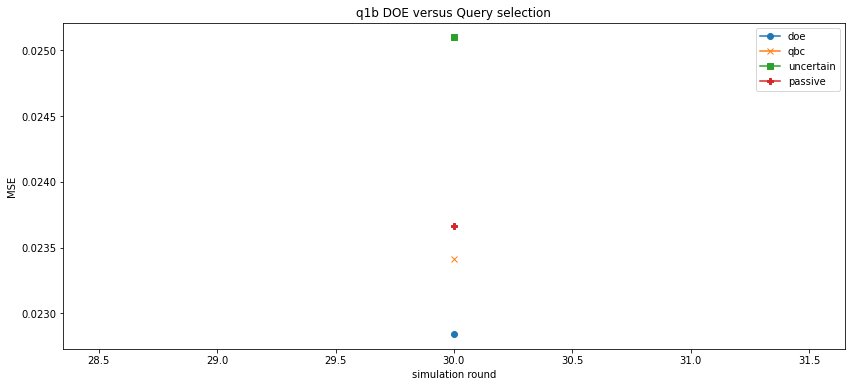

In [32]:
plt.plot(30,np.mean(performance), marker='o', label="doe")
plt.plot(30,qbc_unobsMean[20], marker='x', label="qbc")
plt.plot(30,uncertain_unobsMean[20], marker='s', label='uncertain')
plt.plot(30,passive_unobsMean[20], marker="P", label='passive')
plt.ylabel("MSE")
plt.xlabel("simulation round")
plt.legend()
plt.title("q1b DOE versus Query selection")
plt.show()

In [30]:
def doe_init(x, y):
    xMax, xUnMax, yMax, yUnMax = drawSample(x, y, 10)
    for i in range(10000):
        xObs, xUnob, yObs, yUnob = drawSample(x, y, 10)
        xtx = np.matmul(np.transpose(xObs), xObs)
        curX = np.linalg.det(np.matmul(np.transpose(xMax), xMax))
        if np.linalg.det(xtx) > curX:
            xMax = xObs
            xUnMax = xUnob
            yMax = yObs
            yUnMax = yUnob
    model, train = crossValidation(xMax, yMax)
    return xMax, xUnMax, yMax, yUnMax

In [33]:
def uncertainTrain_doe(x, y):
    xObs, xUnob, yObs, yUnob = doe_init(x, y)
    trainError, testError = [], []
    while len(xObs) < 51:
        model, train = crossValidation(xObs, yObs) 
        trainError.append(train)
        testError.append(mean_squared_error(yUnob, model.predict(xUnob)))
        # update sample
        xNew, yNew, xUnob, yUnob = uncertainSample(model,xObs, yObs, xUnob, yUnob)
        xObs = np.concatenate((xObs, [xNew]))
        yObs = np.concatenate((yObs, [yNew]))
    return trainError, testError

In [38]:
uncertain_doe = []
for i in range(10):
    random.seed(i)
    print(i)
    _, test2 = uncertainTrain_doe(x, y)
    uncertain_doe.append(test2)

# calculate metrics
uncertain2_Mean = [np.mean(i) for i in np.transpose(np.array(uncertain_doe))]
uncertain2_Std = [np.std(i) for i in np.transpose(np.array(uncertain_doe))]

0
1
2
3
4
5
6
7
8
9


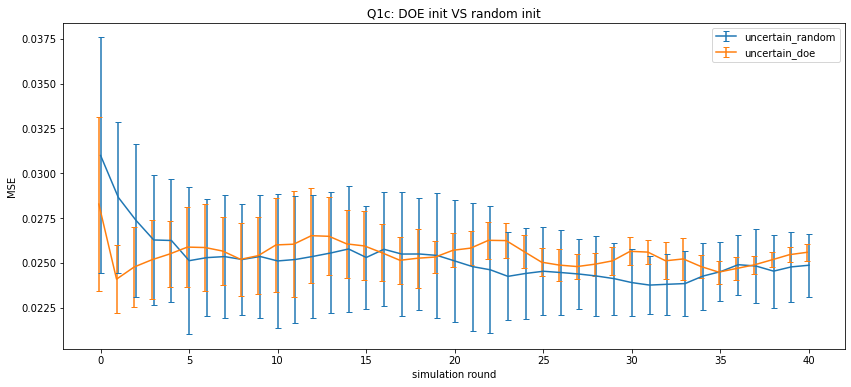

In [39]:
xaxis = np.arange(len(uncertain2_Mean))
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(xaxis, uncertain_unobsMean, yerr = uncertain_unobsStd , label = 'uncertain_random', capsize=3)
plt.errorbar(xaxis-0.1, uncertain2_Mean, yerr = uncertain2_Std,  label = 'uncertain_doe', capsize=3)

plt.xlabel("simulation round")
plt.ylabel("MSE")
plt.title("Q1c: DOE init VS random init")
plt.legend()
plt.show()

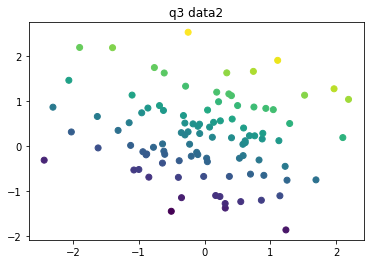

In [46]:
# E3
# generate dataset
d1 = datasets.make_regression(n_features=2, n_informative=2, random_state=1, noise=0.1)
plt.scatter(d1[0][:, 0], d1[0][:, 1],c=d1[1])
plt.title("q3 data2")
plt.show() 

uncertain 0
uncertain 1
uncertain 2
uncertain 3
uncertain 4
uncertain 5
uncertain 6
uncertain 7
uncertain 8
uncertain 9
DOE 0
DOE 1
DOE 2
DOE 3
DOE 4
DOE 5
DOE 6
DOE 7
DOE 8
DOE 9


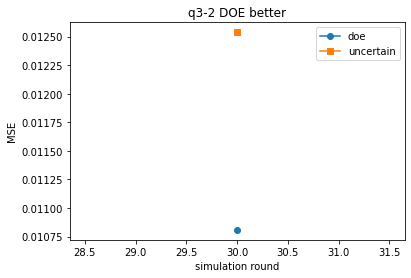

In [18]:
# run simulation DOE vs uncertainty sampling
uncertainError, doeError = [], []
# calculate averaged DOE MSE
for i in range(10):
    random.seed(i)
    print("uncertain", i)
    tE, _ = doe(d1[0], d1[1])
    doeError.append(tE)
# averaged Uncertainty Sampling trainig MSE at round 30
for i in range(10):
    random.seed(i)
    print("DOE", i)
    tE, _ = uncertainTrain(d1[0], d1[1])
    uncertainError.append(tE)

uncertainMean = [np.mean(i) for i in np.transpose(np.array(uncertainError))][20]
#print(np.mean(doeError), uncertainMean)

plt.plot(30,np.mean(doeError), marker='o', label="doe")
plt.plot(30,uncertainMean, marker='s', label='uncertain')
plt.ylabel("MSE")
plt.xlabel("simulation round")
plt.legend()
plt.title("q3-2 DOE better")
plt.show()

In [32]:
# E3 data 2 
d2 = datasets.make_regression(n_features=10, n_informative=2, random_state=1, noise=0.1)

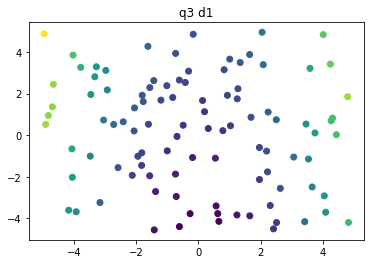

In [47]:
import numpy as np

# Generate random data with two features and high variance
np.random.seed(123)
n_samples = 100
X = np.random.rand(n_samples, 2) * 10 - 5
noise = np.random.randn(n_samples, 1) * 100
y = X[:, 0]**2 + X[:, 1] #+ noise[:, 0]
plt.scatter(X[:,0], X[:,1],c=y)
plt.title("q3 d1")
plt.show()

uncertain 0
uncertain 1
uncertain 2
uncertain 3
uncertain 4
uncertain 5
uncertain 6
uncertain 7
uncertain 8
uncertain 9
DOE 0
DOE 1
DOE 2
DOE 3
DOE 4
DOE 5
DOE 6
DOE 7
DOE 8
DOE 9


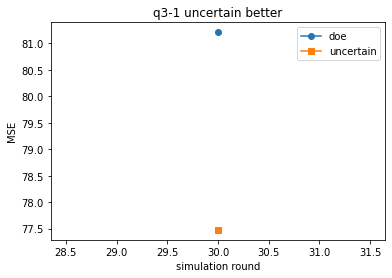

In [45]:
# run simulation DOE vs uncertainty sampling
uncertainError, doeError = [], []
# calculate averaged DOE MSE
for i in range(10):
    random.seed(i)
    print("uncertain", i)
    tE, _ = doe(X, y)
    doeError.append(tE)
# averaged Uncertainty Sampling trainig MSE at round 30
for i in range(10):
    random.seed(i)
    print("DOE", i)
    tE, _ = uncertainTrain(X, y)
    uncertainError.append(tE)

uncertainMean = [np.mean(i) for i in np.transpose(np.array(uncertainError))][20]
#print(np.mean(doeError), uncertainMean)

plt.plot(30,np.mean(doeError), marker='o', label="doe")
plt.plot(30,uncertainMean, marker='s', label='uncertain')
plt.ylabel("MSE")
plt.xlabel("simulation round")
plt.legend()
plt.title("q3-1 uncertain better")
plt.show()